In [85]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
import scipy.io as sp
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [87]:
data_path = '/home/sean/mea data/vglut01/vglut01_170918/vglut01_spk_freq_table_170918.csv'
data_table = pd.read_csv(data_path)
stim_times = pd.read_csv('/home/sean/mea_analysis/matlab/stim_times.csv')
stim_starts = mc.create_stim_starts(stim_times)

In [9]:
def is_top(unit_name):
    row = mc.get_row_number(unit_name)
    if row <= 3:
        return True
    else:
        return False
    
def is_bottom(unit_name):
    row = mc.get_row_number(unit_name)
    if row > 3:
        return True
    else:
        return False

cond_filt = {
    'top': is_top,
    'bottom': is_bottom
}

In [10]:
cat_table = plotting.construct_categorized_dataframe(data_table, cond_filt)
cat_table['spike_freq'] = cat_table['spike_freq']/60 # convert from spikes/1 minute to spikes/sec

In [11]:
cat_table['spike_freq'] = cat_table['spike_freq']/2 # convert from spikes/sec to spikes/pulse

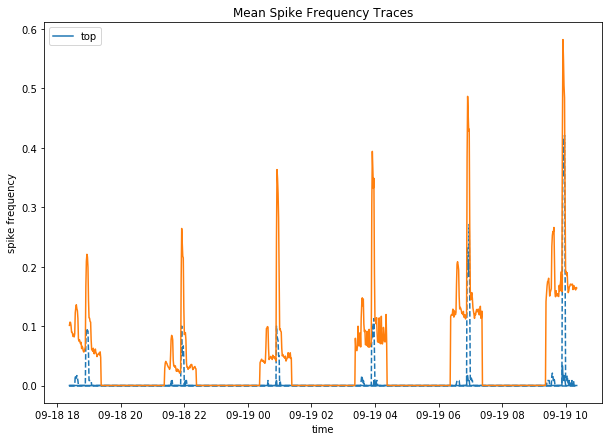

In [15]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table.query('condition == "top"'))
plotting.plot_mean_frequency_traces(cat_table.query('condition == "top"'))

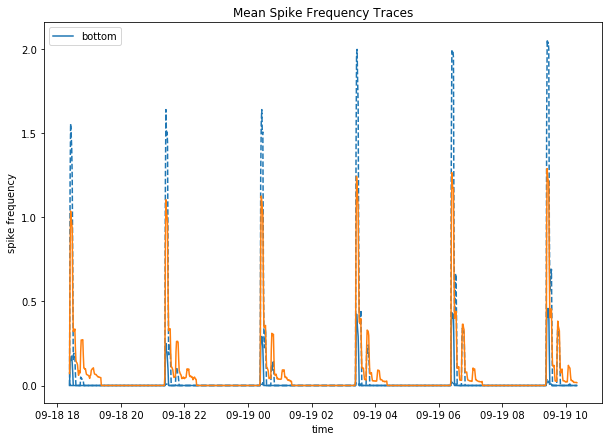

In [16]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table.query('condition == "bottom"'))
plotting.plot_mean_frequency_traces(cat_table.query('condition == "bottom"'))

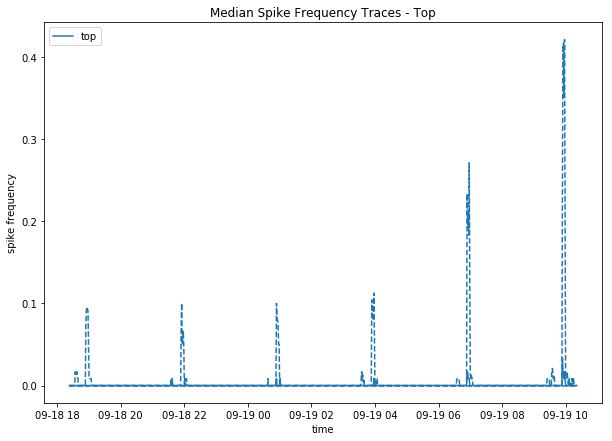

In [17]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table.query('condition == "top"'), quartiles = True)
plt.title("Median Spike Frequency Traces - Top")

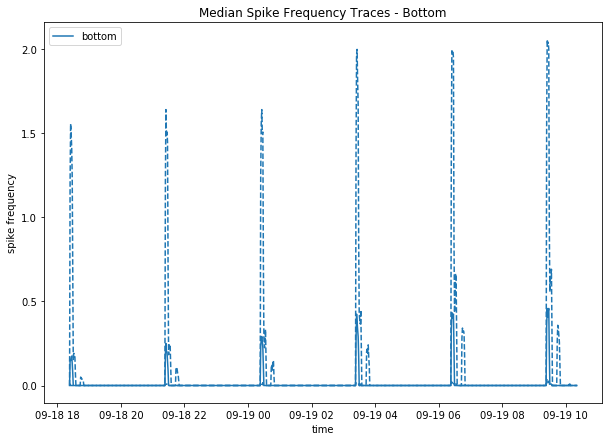

In [18]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table.query('condition == "bottom"'), quartiles = True)
plt.title("Median Spike Frequency Traces - Bottom")

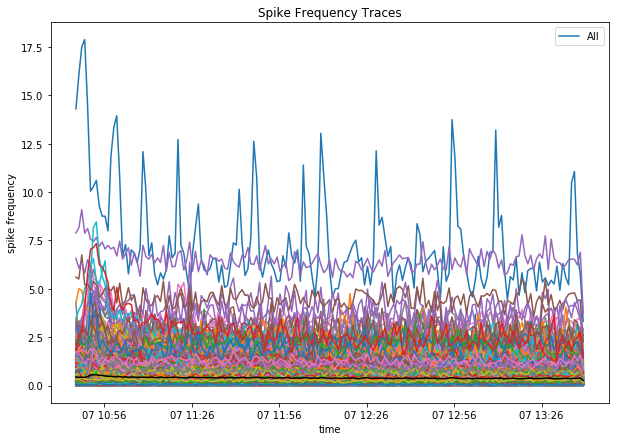

In [12]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(baseline_table)

In [27]:
rec_start_times = pd.date_range('2017-09-18 18:22:00', periods = 6, freq ='3H') #skip 1st minute
rec_stop_times = pd.date_range('2017-09-18 19:22:00', periods = 6, freq='3H')

all_recs_table = pd.DataFrame()

for start, stop in zip(rec_start_times, rec_stop_times):
    rec_table = cat_table.query('time > @start and time < @stop')
    rec_table.loc[:,'time'] = rec_table.loc[:,'time'] - start
    all_recs_table = all_recs_table.append(rec_table)

rec_mean = all_recs_table.groupby(('condition','time'))['spike_freq'].mean()
rec_mean = rec_mean.reset_index()

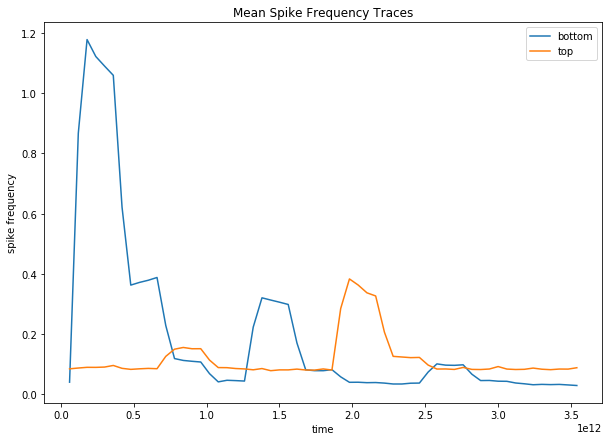

In [28]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(all_recs_table)

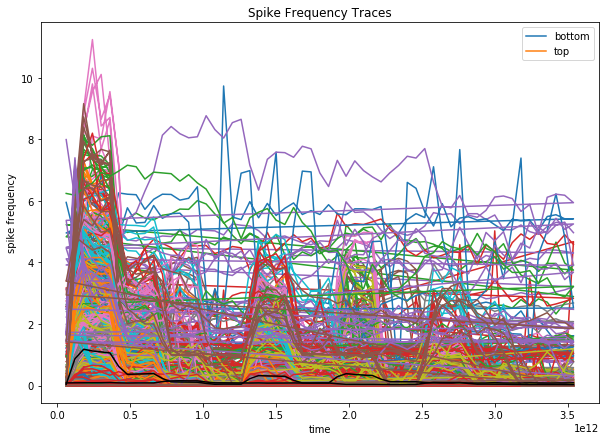

In [29]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(all_recs_table)

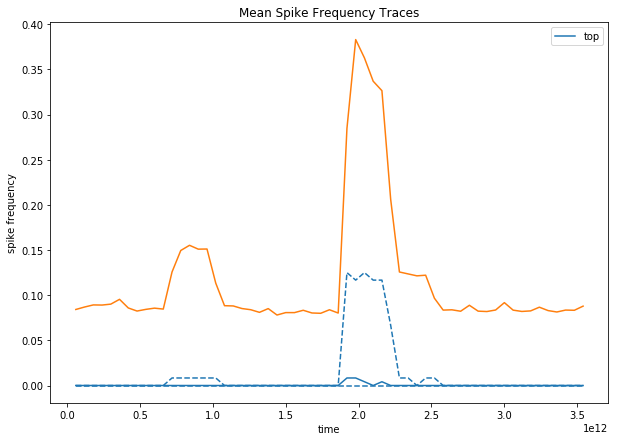

In [30]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(all_recs_table.query('condition == "top"'))
plotting.plot_mean_frequency_traces(all_recs_table.query('condition == "top"'))

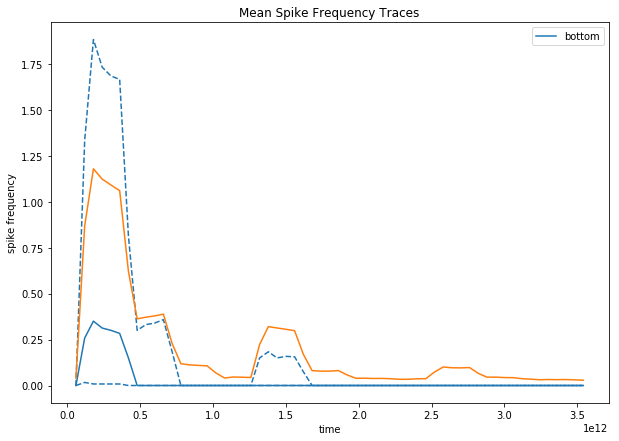

In [32]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(all_recs_table.query('condition == "bottom"'))
plotting.plot_mean_frequency_traces(all_recs_table.query('condition == "bottom"'))

In [33]:
def light_response_filter(all_recs_table):
    high_resp = all_recs_table.query('time >= "00:30:00" and time < "00:35:00"')
    high_means = high_resp.groupby('unit_name')['spike_freq'].mean()
    high_means = high_means.reset_index()
    low_resp = all_recs_table.query('time >= "00:50:00" and time < "00:60:00"')
    low_means = low_resp.groupby('unit_name')['spike_freq'].mean()
    low_means = low_means.reset_index()
    filt = high_means['spike_freq'] > low_means['spike_freq']
    return high_means.loc[filt,'unit_name']

In [34]:
filtered_units = light_response_filter(all_recs_table)
filtered_table = all_recs_table.loc[all_recs_table['unit_name'].isin(filtered_units)]

In [35]:
(slow_table, slow_units) = plotting.select_neurons(filtered_table, min_freq = 0.01, max_freq = 0.03)
(fast_table, fast_units) = plotting.select_neurons(filtered_table, min_freq = 0.8)
(non_zero_table, non_zero_units) = plotting.select_neurons(filtered_table, min_freq = 0.01)

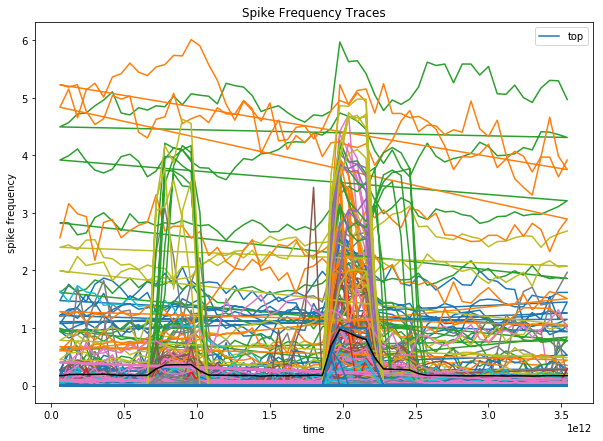

In [38]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(non_zero_table.query('condition == "top"'))
#plt.yscale('log')

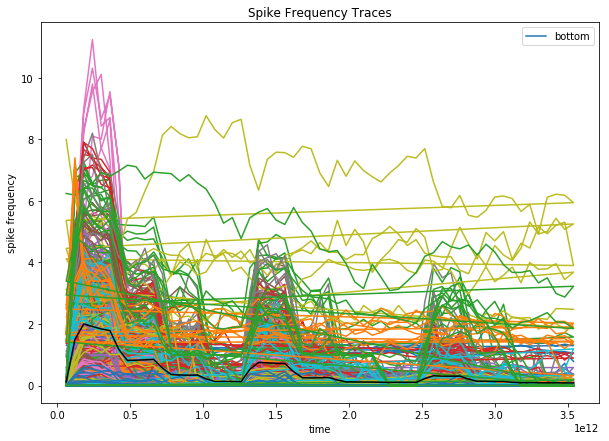

In [41]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(non_zero_table.query('condition == "bottom"'))
#plt.yscale('log')

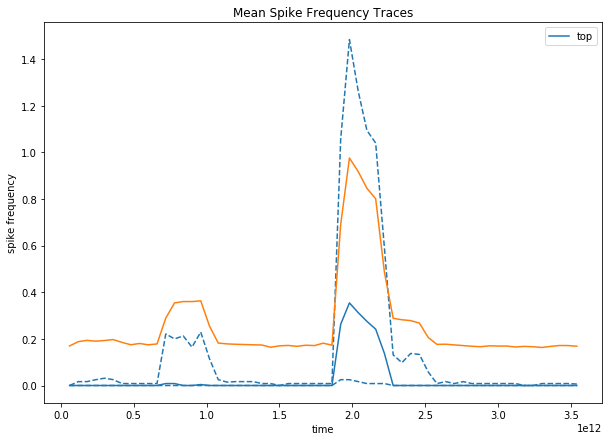

In [44]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(non_zero_table.query('condition == "top"'))
plotting.plot_mean_frequency_traces(non_zero_table.query('condition == "top"'))

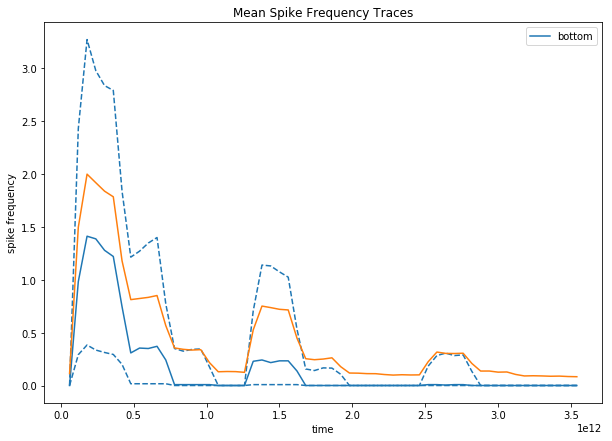

In [43]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(non_zero_table.query('condition == "bottom"'))
plotting.plot_mean_frequency_traces(non_zero_table.query('condition == "bottom"'))

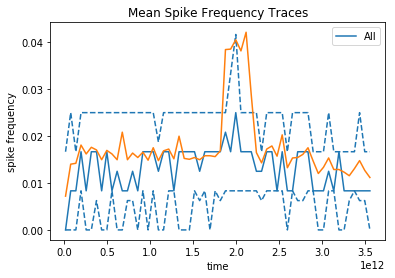

In [80]:
plotting.plot_median_frequency_traces(slow_table)
plotting.plot_mean_frequency_traces(slow_table)

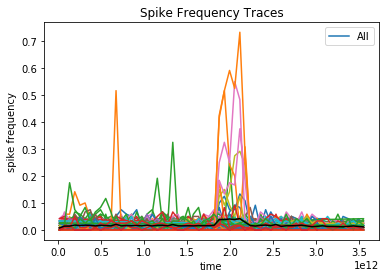

In [22]:
plotting.plot_unit_traces_plus_means(slow_table)

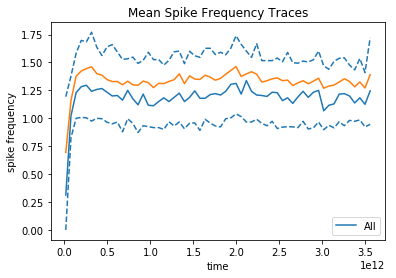

In [81]:
plotting.plot_median_frequency_traces(fast_table)
plotting.plot_mean_frequency_traces(fast_table)

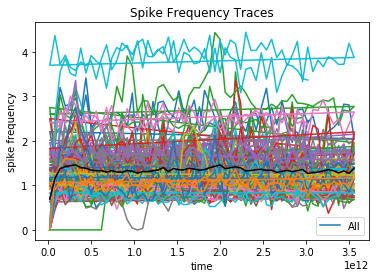

In [23]:
plotting.plot_unit_traces_plus_means(fast_table)

In [58]:
def mean_freq_hist(category_dataframe, num_bins = 50):
    unit_freq_mean = category_dataframe.groupby(('unit_name'))['spike_freq'].mean()
    unit_freq_mean = unit_freq_mean.rename('spike frequency').reset_index() # Convert the multiindexed series back to a dataframe
    plt.hist(unit_freq_mean['spike frequency'], bins = num_bins)
    plt.title('Mean Firing Rate per Unit')

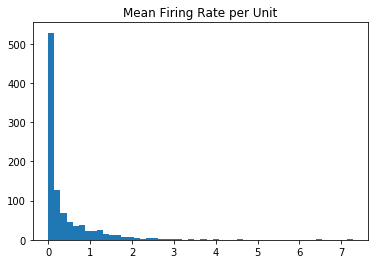

In [143]:
mean_freq_hist(baseline_table)

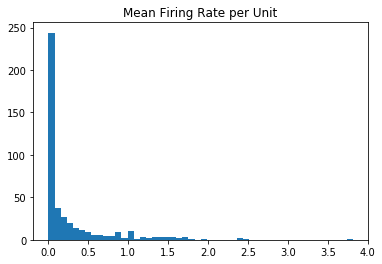

In [144]:
mean_freq_hist(filtered_table)

52
44


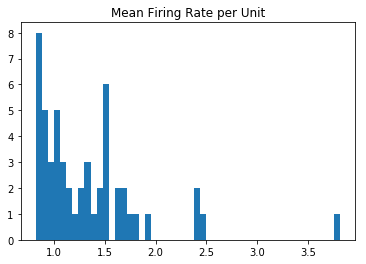

In [82]:
mean_freq_hist(fast_table)
print(len(fast_table['unit_name'].unique()))
print(len(slow_table['unit_name'].unique()))

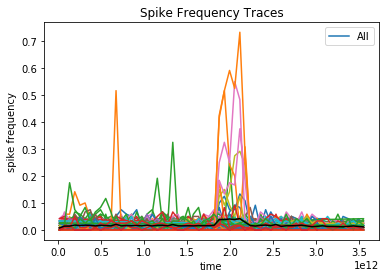

In [83]:
plotting.plot_unit_traces_plus_means(slow_table)

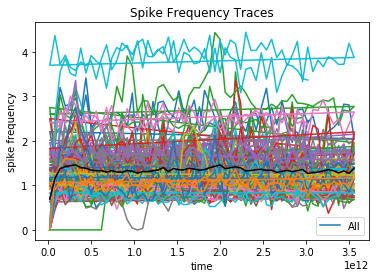

In [84]:
plotting.plot_unit_traces_plus_means(fast_table)

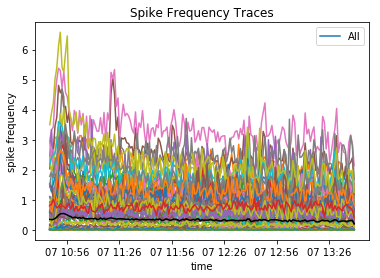

In [148]:
plotting.plot_unit_traces_plus_means(baseline_table.loc[baseline_table['unit_name'].isin(slow_units)])

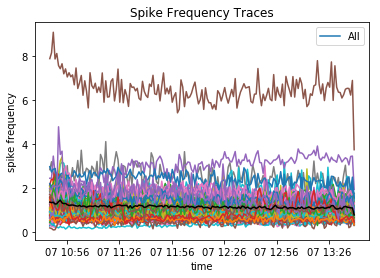

In [149]:
plotting.plot_unit_traces_plus_means(baseline_table.loc[baseline_table['unit_name'].isin(fast_units)])